## Defining Constants

In [17]:
ART_DIR = "artifacts"
ID_COL = "district_id"
VARIANTS = ["full", "norace"]

In [18]:
import os, json, glob, math
from pathlib import Path
import numpy as np
import pandas as pd
import joblib
from texas_gerrymandering_hb4.config import CLEAN_DISTRICTS_PARQUET, IMAGES_DIR

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import re as _re

try:
    import geopandas as gpd
except Exception:
    gpd = None


## Helper Functions

In [19]:
def ensure_artifacts_dir():
    os.makedirs(ART_DIR, exist_ok=True)

In [20]:
def load_X(variant: str) -> np.ndarray:
    path = f"{ART_DIR}/X_{variant}_scaled.npz"
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing {path}. Run 01_preprocess/02_train first.")
    arr = np.load(path)
    if "X" not in arr:
        raise KeyError(f"'X' not found in {path}.")
    X = arr["X"]
    if X.ndim != 2:
        raise ValueError(f"X must be 2D; got {X.shape}")
    return X

In [21]:
def load_ids() -> pd.DataFrame:
    path = f"{ART_DIR}/district_ids.csv"
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing {path}.")
    ids = pd.read_csv(path)
    if ID_COL not in ids.columns:
        raise KeyError(f"Expected column '{ID_COL}' in {path}.")
    return ids

In [22]:
def detect_k_for_variant(variant: str) -> int:
    metas = sorted(glob.glob(f"{ART_DIR}/trainmeta_{variant}_k*.json"), key=os.path.getmtime, reverse=True)
    if metas:
        latest = metas[0]
        with open(latest, "r") as f:
            meta = json.load(f)
        return int(meta.get("k"))
    clusters = sorted(glob.glob(f"{ART_DIR}/clusters_{variant}_k*.csv"), key=os.path.getmtime, reverse=True)
    if clusters:
        fname = Path(clusters[0]).name
        try:
            k = int(fname.split("_k")[-1].split(".")[0])
            return k
        except Exception:
            pass
    raise FileNotFoundError(f"Could not detect k for variant='{variant}'. Ensure 02_train artifacts exist.")

In [23]:
def load_model_and_labels(variant: str, k: int):
    model_path = f"{ART_DIR}/kmeans_{variant}_k{k}.joblib"
    clusters_path = f"{ART_DIR}/clusters_{variant}_k{k}.csv"
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Missing {model_path}")
    if not os.path.exists(clusters_path):
        raise FileNotFoundError(f"Missing {clusters_path}")
    km = joblib.load(model_path)
    labels_df = pd.read_csv(clusters_path)
    label_col = f"cluster_{variant}_k{k}"
    if label_col not in labels_df.columns:
        raise KeyError(f"Expected '{label_col}' in {clusters_path}.")
    return km, labels_df, label_col

## Evaluation Utils

In [24]:
IMAGES_DIR.mkdir(parents=True, exist_ok=True)

def pca_scatter(X: np.ndarray, labels: np.ndarray, variant: str, k: int, title: str):
    p = PCA(n_components=2).fit_transform(X)
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.scatter(p[:,0], p[:,1], c=labels)
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    fig.tight_layout()
    output_path = IMAGES_DIR / f"kmeans_pca_{variant}_k{k}.png"
    fig.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print(f"[visuals] Saved PCA scatter to: {output_path}")



In [25]:
def centroid_profiles(km, feature_names=None):
    C = km.cluster_centers_
    df_mean = pd.DataFrame(C, columns=feature_names or [f"x{i}" for i in range(C.shape[1])])
    z = (df_mean - df_mean.mean(axis=0)) / (df_mean.std(axis=0).replace(0, np.nan))
    df_z = z.add_prefix("z_")
    out = pd.concat([df_mean, df_z], axis=1)
    out.insert(0, "cluster", range(C.shape[0]))
    return out

In [26]:
def plot_centroid_heatmap(df_profiles: pd.DataFrame, title: str):
    zcols = [c for c in df_profiles.columns if c.startswith("z_")]
    M = df_profiles[zcols].to_numpy()
    plt.figure(figsize=(8, 0.5*M.shape[0] + 2))
    plt.imshow(M, aspect="auto")
    plt.colorbar(label="z-score")
    plt.yticks(range(M.shape[0]), df_profiles["cluster"].tolist())
    plt.xticks(range(len(zcols)), zcols, rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [27]:
def distances_to_assigned_centroid(km, X, labels):
    D = km.transform(X)
    assigned = D[np.arange(D.shape[0]), labels]
    return assigned

In [28]:
def geo_file_if_exists():
    candidates = [
        f"{ART_DIR}/districts_clean.parquet",
        CLEAN_DISTRICTS_PARQUET,
    ]
    for p in candidates:
        if os.path.exists(p):
            return p
    return None

In [29]:
def _to_district_id(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip()
    def norm(x: str):
        digits = _re.sub(r"\D", "", x)
        if digits == "":
            return np.nan
        d = int(digits[-2:]) if len(digits) >= 2 else int(digits)
        return d if 1 <= d <= 38 else np.nan
    return s.map(norm)

In [30]:
def _ensure_district_id(gdf):
    if "district_id" in gdf.columns:
        try:
            return gdf.assign(district_id=pd.to_numeric(gdf["district_id"], errors="raise").astype(int))
        except Exception:
            pass
    candidates = [
        "district","districtid","cd","cd_id","DISTRICT_ID","District_ID",
        "DISTRICT","DIST","CD","CD118","CD116","GEOID","geoid"
    ]
    cols_lc = {c.lower(): c for c in gdf.columns}
    for c in candidates:
        col = c if c in gdf.columns else cols_lc.get(c.lower())
        if col:
            cand = _to_district_id(gdf[col])
            if cand.notna().all():
                return gdf.assign(district_id=cand.astype(int))
    # brute-force try all non-geometry columns
    for col in gdf.columns:
        if col == "geometry":
            continue
        cand = _to_district_id(gdf[col])
        if cand.notna().all():
            return gdf.assign(district_id=cand.astype(int))
    raise KeyError("Could not construct 'district_id' from any geo column.")


## Evaluate One Variant

In [31]:
def evaluate_variant(variant: str):
    ensure_artifacts_dir()
    k = detect_k_for_variant(variant)
    X = load_X(variant)
    ids = load_ids()
    km, labels_df, label_col = load_model_and_labels(variant, k)
    labels = labels_df[label_col].to_numpy()
    if len(ids) != X.shape[0] or len(labels_df) != X.shape[0]:
        raise ValueError("Row alignment mismatch among X, ids, or labels.")
    # Metrics
    try:
        sil = float(silhouette_score(X, labels))
    except Exception:
        sil = float("nan")
    try:
        ch = float(calinski_harabasz_score(X, labels))
    except Exception:
        ch = float("nan")
    try:
        db = float(davies_bouldin_score(X, labels))
    except Exception:
        db = float("nan")
    inertia = float(getattr(km, "inertia_", float("nan")))

    uniq, cnts = np.unique(labels, return_counts=True)
    sizes = dict(zip(uniq.tolist(), cnts.tolist()))

    print(f"[{variant}] k={k} | n={X.shape[0]}x{X.shape[1]} | inertia={inertia:.3f} | silhouette={sil if sil==sil else 'NA'} | CH={ch if ch==ch else 'NA'} | DB={db if db==db else 'NA'}")
    print("Cluster sizes:", sizes)
    # PCA scatter
    pca_scatter(X, labels, variant, k, title=f"{variant} | k={k} | PCA scatter")
    # Profiles
    feat_names = [f"x{i}" for i in range(X.shape[1])]
    prof = centroid_profiles(km, feature_names=feat_names)
    plot_centroid_heatmap(prof, title=f"{variant} | k={k} | centroid z-scores")
    # Distances
    dist = distances_to_assigned_centroid(km, X, labels)
    assign = ids.copy()
    assign[label_col] = labels
    assign["dist_to_centroid"] = dist
    # Persist outputs
    summary = {
        "variant": variant, "k": int(k),
        "n_samples": int(X.shape[0]), "n_features": int(X.shape[1]),
        "inertia": inertia, "silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": db,
        "sizes": sizes,
    }
    with open(f"{ART_DIR}/eval_summary_{variant}_k{k}.json", "w") as f:
        json.dump(summary, f, indent=2)
    prof.to_csv(f"{ART_DIR}/cluster_profiles_{variant}_k{k}.csv", index=False)
    assign.to_csv(f"{ART_DIR}/sample_assignments_{variant}_k{k}.csv", index=False)

    geo_path = geo_file_if_exists()
    if gpd is not None and geo_path is not None:
        try:
            gdf = gpd.read_parquet(geo_path)
            gdf = _ensure_district_id(gdf)
            gdf_merged = gdf.merge(assign[[ID_COL, label_col]], left_on="district_id", right_on=ID_COL, how="left")
            out_geo = f"{ART_DIR}/districts_clusters_{variant}_k{k}.parquet"
            gdf_merged.to_parquet(out_geo)
            print(f"[{variant}] GeoParquet with clusters -> {out_geo}")
        except Exception as e:
            print(f"[{variant}] Skipped Geo export: {e}")
    else:
        print(f"[{variant}] No geometry export: geopandas not available or districts geometry file missing.")
    return {"k": k, "summary": summary}


## Run Evaluation for All Variants

[full] k=2 | n=38x10 | inertia=280.374 | silhouette=0.2831376329426156 | CH=12.792038892812087 | DB=1.529870169167291
Cluster sizes: {0: 13, 1: 25}


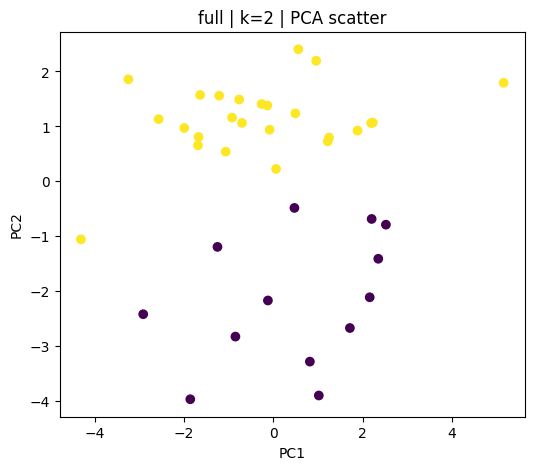

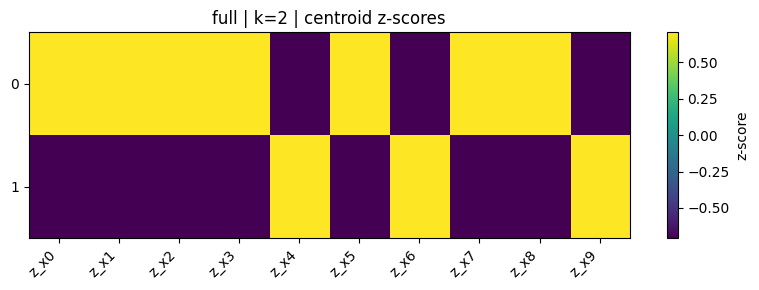

[full] GeoParquet with clusters -> artifacts/districts_clusters_full_k2.parquet
[norace] k=10 | n=38x6 | inertia=25.544 | silhouette=0.36929174706501755 | CH=24.657574681705317 | DB=0.7286036764458146
Cluster sizes: {0: 7, 1: 9, 2: 2, 3: 2, 4: 2, 5: 5, 6: 2, 7: 1, 8: 2, 9: 6}


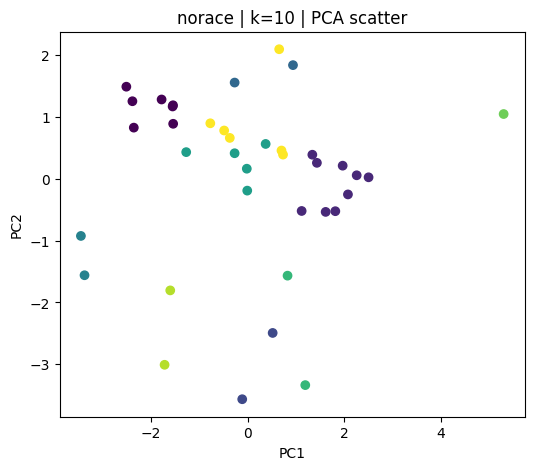

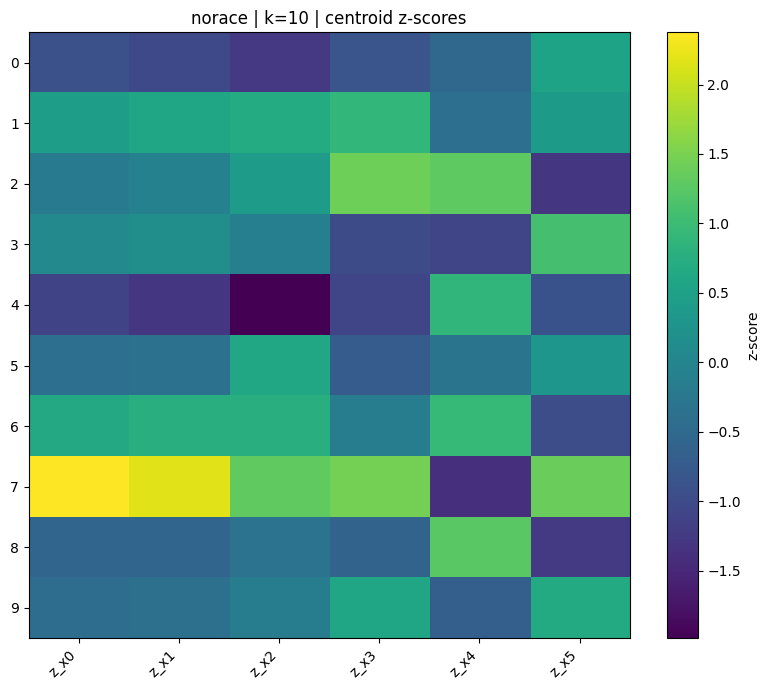

[norace] GeoParquet with clusters -> artifacts/districts_clusters_norace_k10.parquet
Done. See artifacts/:
 - eval_summary_{variant}_k{K}.json
 - cluster_profiles_{variant}_k{K}.csv
 - sample_assignments_{variant}_k{K}.csv
 - districts_clusters_{variant}_k{K}.parquet (if geometry available)


In [32]:
results = {}
for v in VARIANTS:
    try:
        results[v] = evaluate_variant(v)
    except Exception as e:
        print(f"[{v}] Evaluation failed: {e}")
#
print("Done. See artifacts/:")
print(" - eval_summary_{variant}_k{K}.json")
print(" - cluster_profiles_{variant}_k{K}.csv")
print(" - sample_assignments_{variant}_k{K}.csv")
print(" - districts_clusters_{variant}_k{K}.parquet (if geometry available)")